In [1]:
import os
import boto3
import json
import base64
import bedrock_runtime_wrapper

from PIL import Image

In [2]:
# Initialize the Amazon Bedrock runtime client

region = "us-west-2"
claude3_model_id = "anthropic.claude-3-sonnet-20240229-v1:0"

client = boto3.client(service_name="bedrock-runtime", region_name=region)
wrapper = bedrock_runtime_wrapper.BedrockRuntimeWrapper(client)

In [3]:
def set_body(prompt, image, multimodal):
    multimodal_body = {
            "anthropic_version": "bedrock-2023-05-31",
            "max_tokens": 2048,
            "messages": [
                {
                    "role": "user",
                    "content": [
                        {
                            "type": "text",
                            "text": prompt,
                        },
                        {
                            "type": "image",
                            "source": {
                                "type": "base64",
                                "media_type": "image/jpeg",
                                "data": image,
                            },
                        },
                    ],
                }
            ],
        }

    text_only_body = {
            "anthropic_version": "bedrock-2023-05-31",
            "max_tokens": 2048,
            "messages": [
                {
                    "role": "user",
                    "content": [
                        {
                            "type": "text",
                            "text": prompt,
                        },
                    ],
                }
            ],
        }

    if multimodal:
        return multimodal_body
    else:
        return text_only_body

In [4]:
# Invoke Claude3 sonnet model

def invoke_claude3_sonnet_model(prompt, image, multimodal=False):
    """
    Invokes Anthropic Claude 3 Sonnet to run a multimodal inference using the input
    provided in the request body.

    :param prompt:            The prompt that you want Claude 3 to use.
    :param base64_image_data: The base64-encoded image that you want to add to the request.
    :return: Inference response from the model.
    """

    # Invoke the model with the prompt and the encoded image
    model_id = claude3_model_id
    request_body = set_body(prompt, image, multimodal)

    try:
        response = client.invoke_model(
            modelId=model_id,
            body=json.dumps(request_body),
        )

        # Process and print the response
        result = json.loads(response.get("body").read())
        input_tokens = result["usage"]["input_tokens"]
        output_tokens = result["usage"]["output_tokens"]
        output_list = result.get("content", [])

        #print("Invocation details:")
        #print(f"- The input length is {input_tokens} tokens.")
        #print(f"- The output length is {output_tokens} tokens.")

        print(f"- The model returned {len(output_list)} response(s):")
        for output in output_list:
            print(output["text"])

        return result

    except ClientError as err:
        logger.error(
            "Couldn't invoke Claude 3 Sonnet. Here's why: %s: %s",
            err.response["Error"]["Code"],
            err.response["Error"]["Message"],
        )
        raise

In [5]:
# Test Sample #

sample_directory = "sample4"

In [6]:
# Image road & encoding

def encoding_image(image_path):
    with open(image_path, "rb") as image_file:
        encoded_image = base64.b64encode(image_file.read()).decode("utf8")

    return encoded_image

In [7]:
multimodal_text_prompt = "이 이미지를 JSON 으로 속성 및 상품명을 포함해서 한글로 추출해줘"

In [8]:
# Get sample directory files

def get_files_in_folder(sample):
    folder_path = f'samples/{sample}/'
    files = {'target': None, 'associates': []}
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        if os.path.isfile(file_path):
            if 'target' in file_path:
                files['target'] = file_path
            else:
                files['associates'].append(file_path)

    return files


all_items = get_files_in_folder(sample_directory)
print(all_items)

{'target': 'samples/sample4/target.png', 'associates': ['samples/sample4/candi3.png', 'samples/sample4/candi2.png', 'samples/sample4/candi1.png']}


samples/sample4/target.png
- The model returned 1 response(s):
{
  "상품명": "단가라 니트",
  "색상": {
    "주조색": "아이보리",
    "보조색": "네이비"
  },
  "디자인": "복고풍 스트라이프 패턴",
  "소재": "니트",
  "스타일": "캐주얼"
}


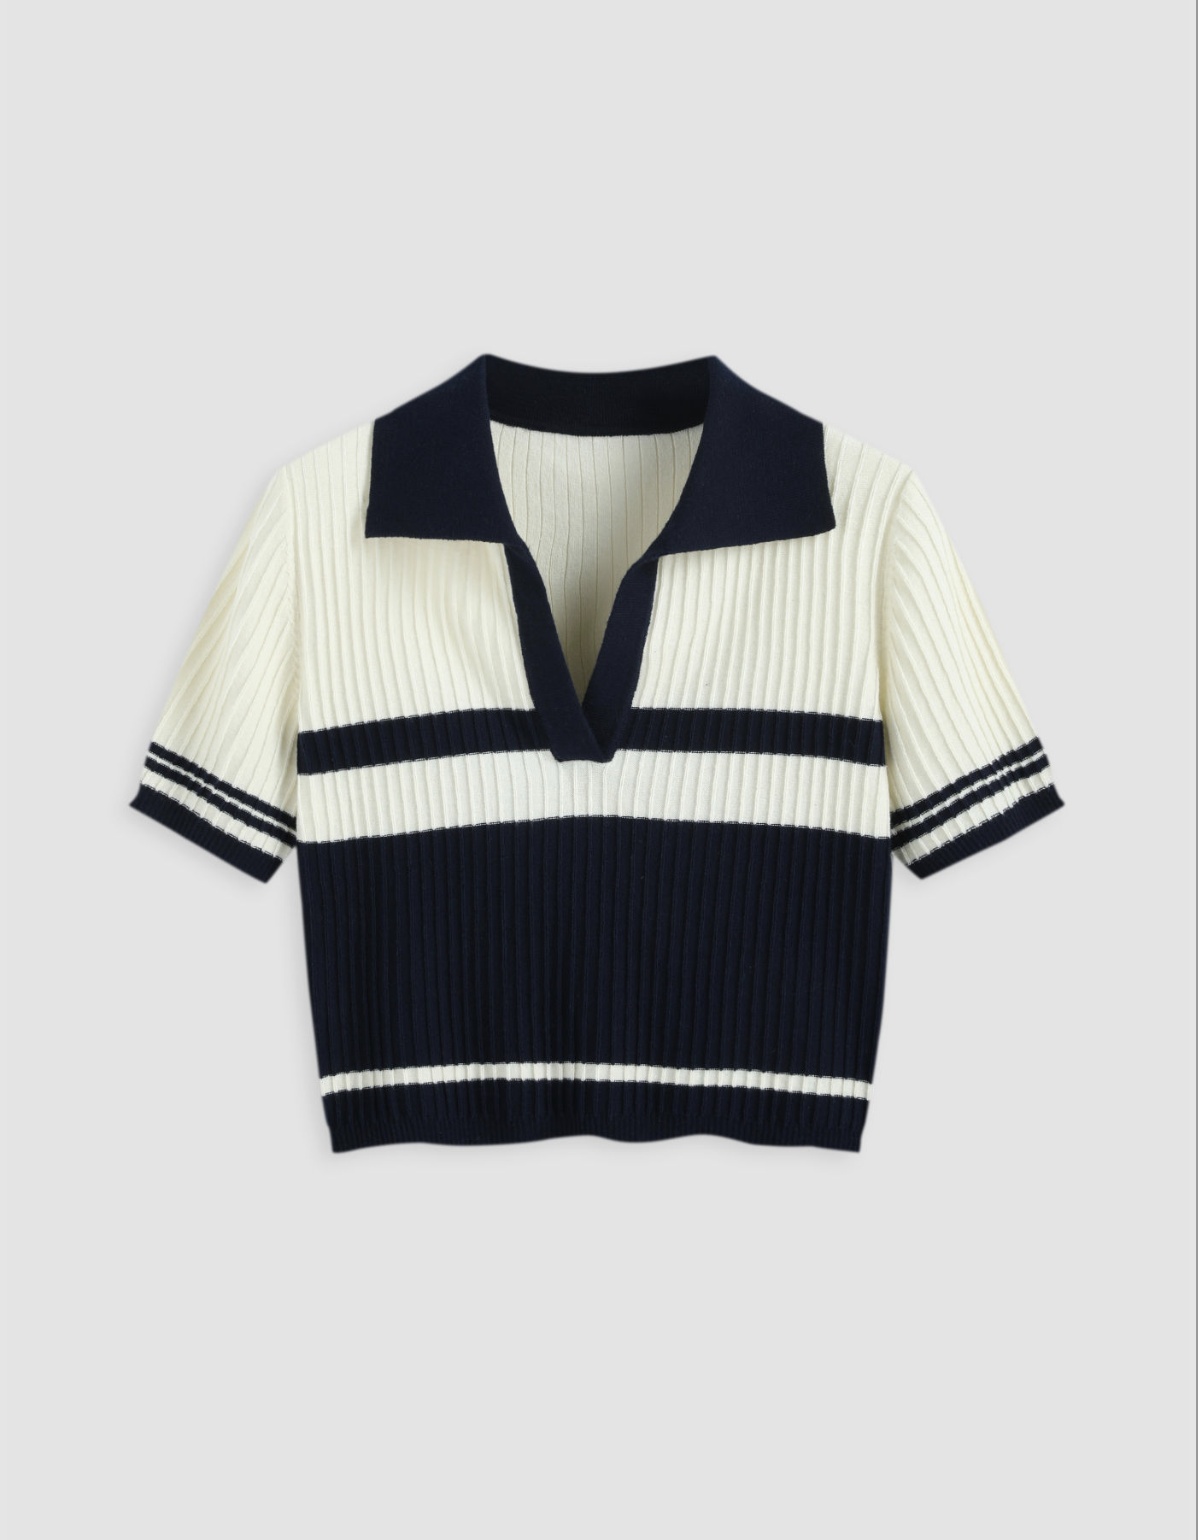

samples/sample4/candi3.png
- The model returned 1 response(s):
{
  "상품명": "스포츠 신발",
  "색상": "네이비",
  "특징": {
    "로고": "삼선 로고",
    "아웃솔": "흰색 고무",
    "국가": ["프랑스", "이탈리아", "네덜란드"]
  },
  "소재": "합성 가죽"
}


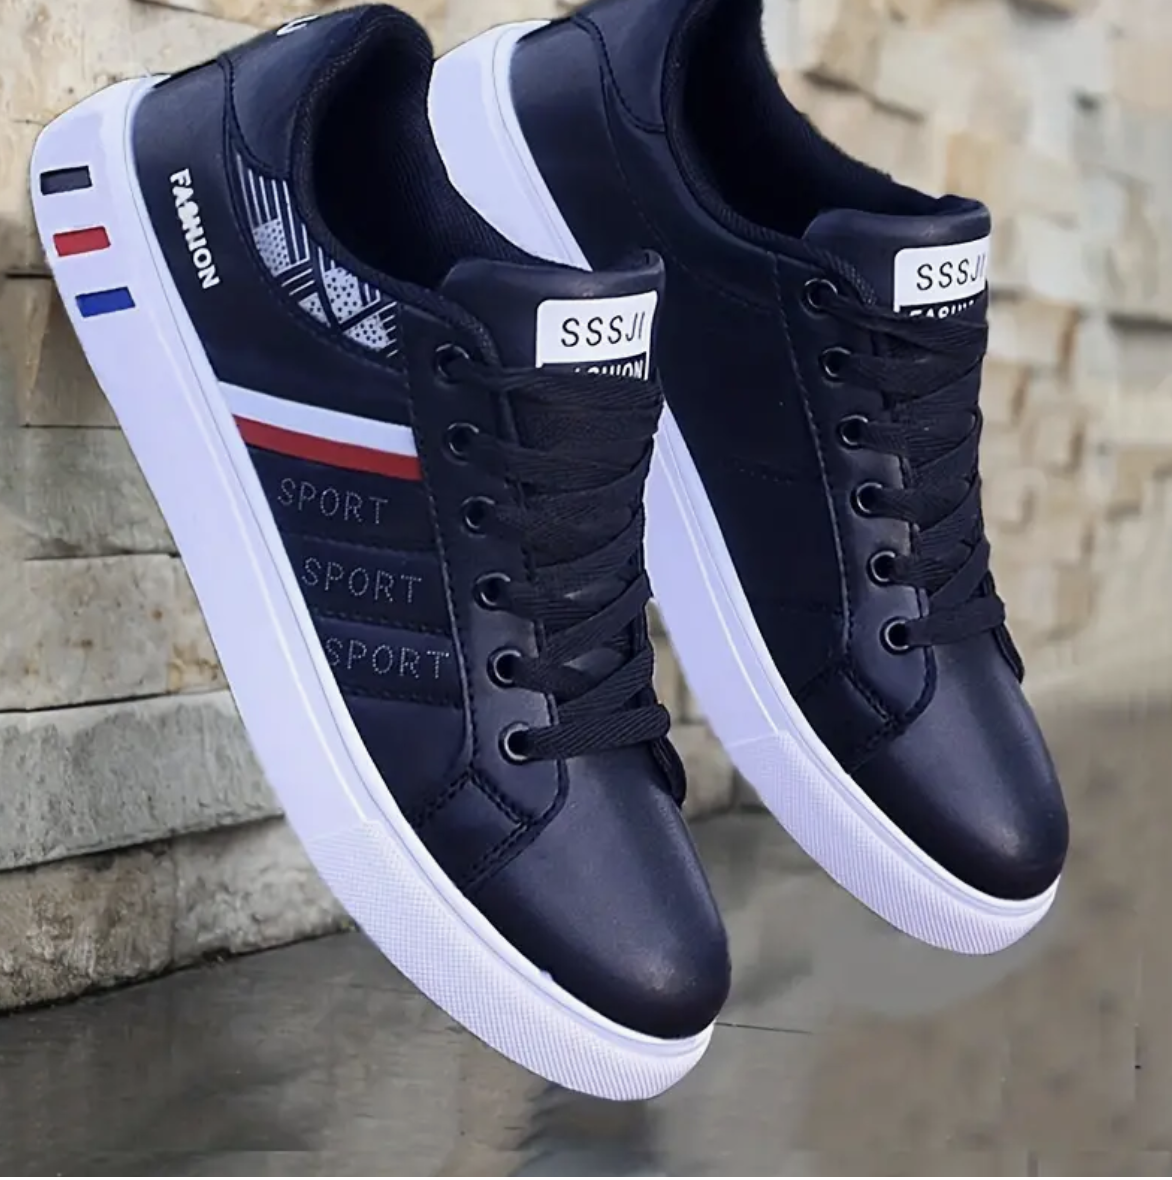

samples/sample4/candi2.png
- The model returned 1 response(s):
{
  "상품명": "학생복",
  "속성": {
    "상의": "흰색 폴로셔츠",
    "하의": "카키색 플리츠 미니스커트"
  }
}


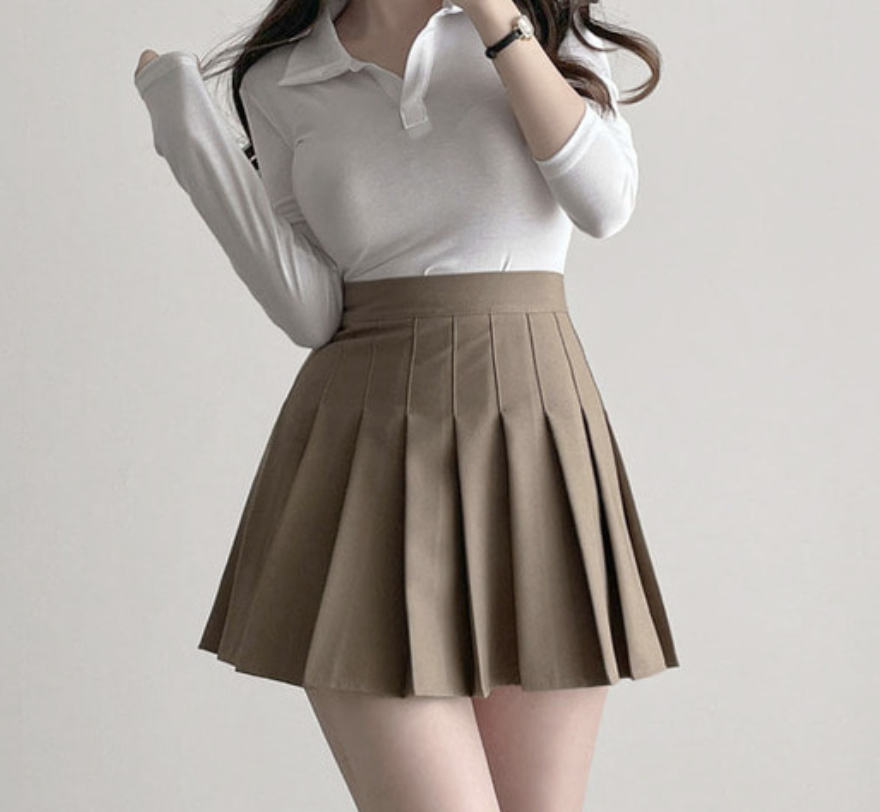

samples/sample4/candi1.png
- The model returned 1 response(s):
{
  "상품명": "와이드 레그 팬츠",
  "소재": "실크",
  "색상": "회색",
  "디자인": "와이드 레그, 높은 허리라인, 주름 디테일",
  "착용자 액세서리": "블랙 오픈토 하이힐"
}


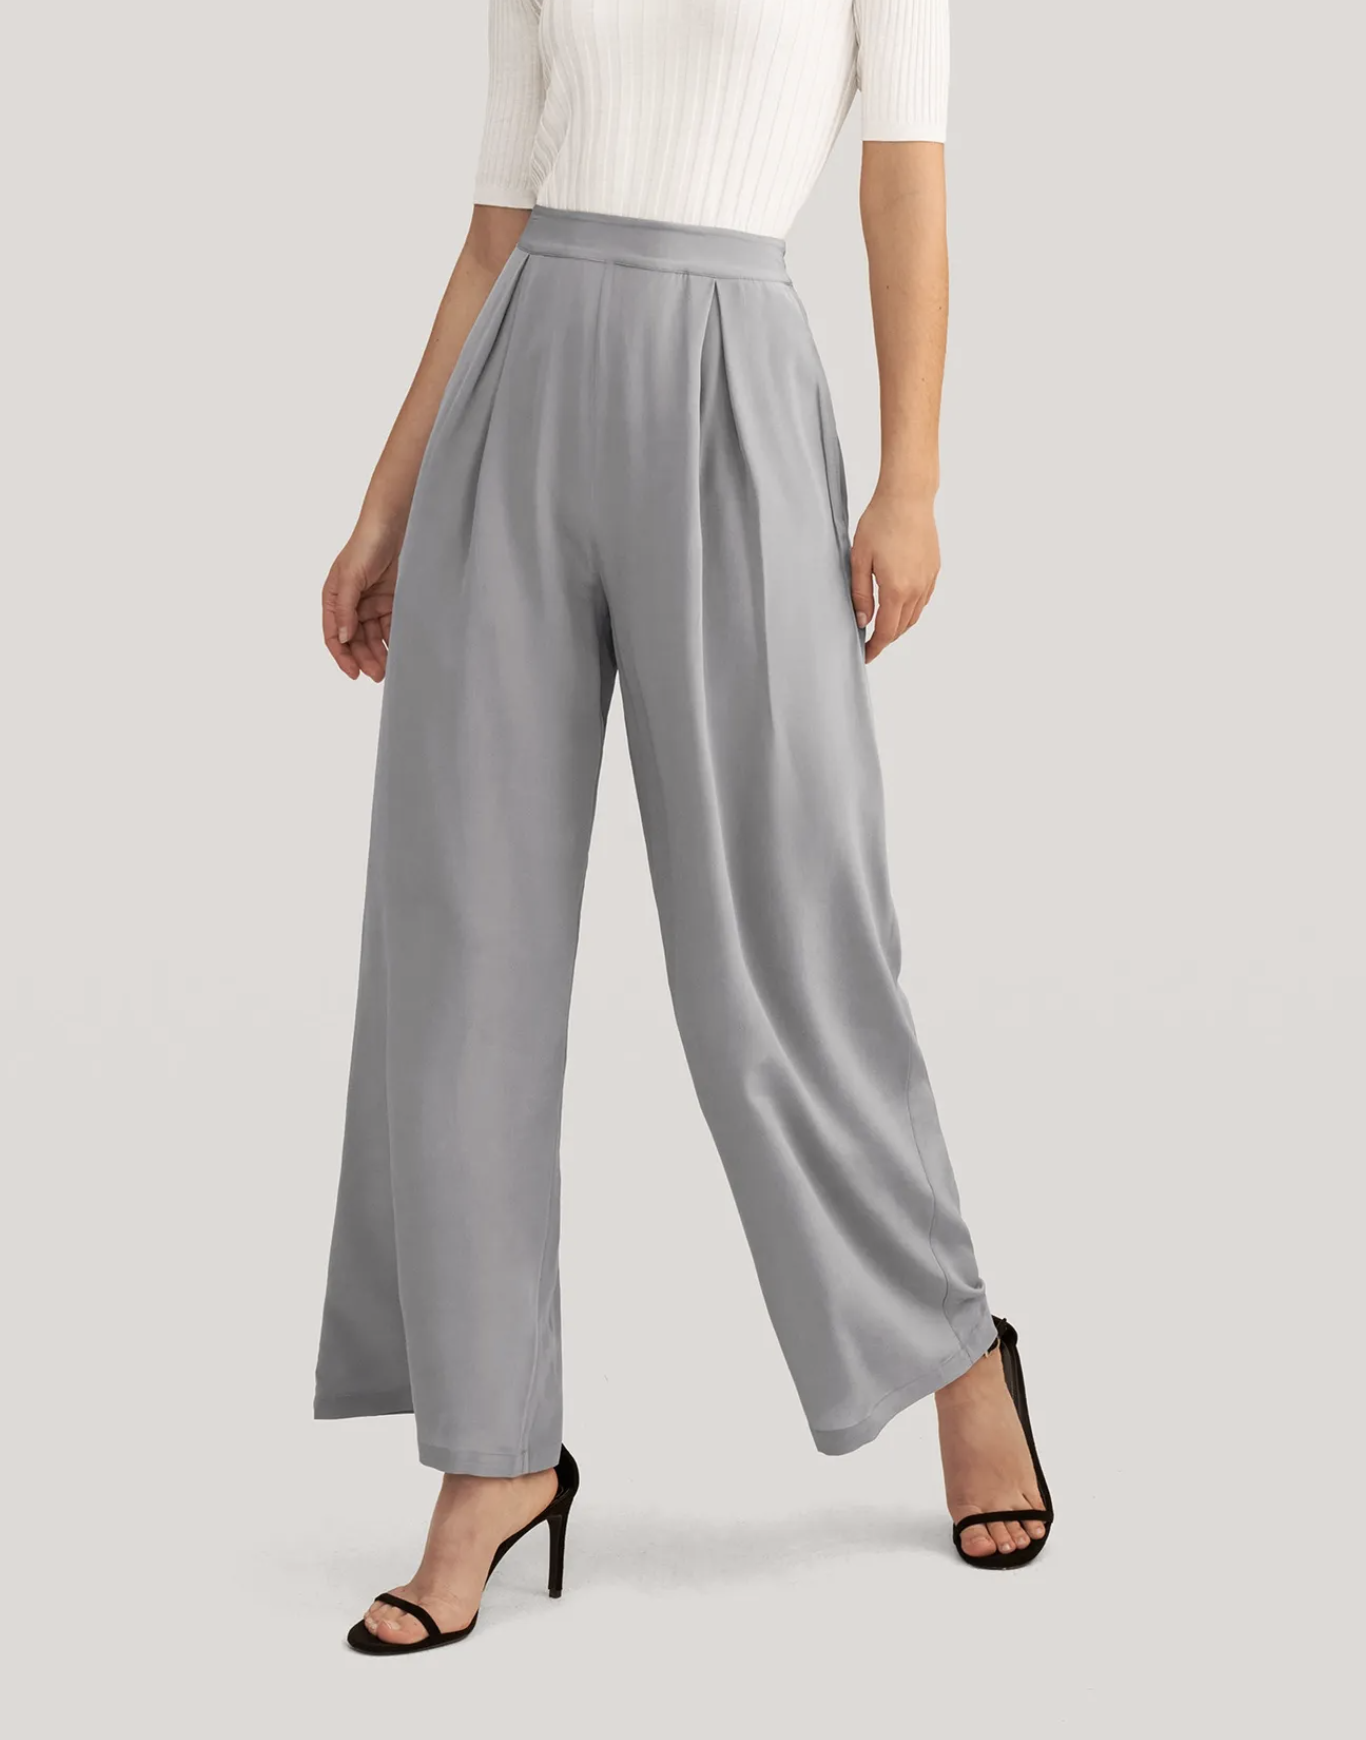

In [9]:
# invoke bedrock

target = None
associates = []
for k, v in all_items.items():
    if 'target' in k:
        print(v)
        target = invoke_claude3_sonnet_model(multimodal_text_prompt,
                                             encoding_image(v), multimodal=True)
        Image.open(v).show()
    else:
        for asso in v:
            print(asso)
            associates.append(invoke_claude3_sonnet_model(
                multimodal_text_prompt, encoding_image(asso), multimodal=True))
            Image.open(asso).show()

In [11]:
fasion_expert_promtpt = f"""당신은 패선 전문가 입니다.
    아래의 <target_product> 상품에 대해서, 관련된 상품 목록이 <associate_product> 에 있습니다.
    <associate_product> 상품 목록안에서 가장 어울리는 상품을 알려주고, 선택한 이유도 알려 주세요.
    답변은 JSON 형식으로 출력 해주세요.
    <target_product>
    {str(target)}
    </target_product>
    <associate_product>
    {str(associates)}
    </associate_product>
    """

In [12]:
invoke_claude3_sonnet_model(fasion_expert_promtpt, None, multimodal=False)

- The model returned 1 response(s):
JSON 응답:

{
  "선택 상품": {
    "상품명": "와이드 레그 팬츠",
    "소재": "실크",
    "색상": "회색",
    "디자인": "와이드 레그, 높은 허리라인, 주름 디테일",
    "착용자 액세서리": "블랙 오픈토 하이힐"
  },
  "선택 이유": "타겟 상품인 '단가라 니트'와 잘 어울리는 스타일로, 캐주얼하면서도 세련된 복고풍 무드를 연출할 수 있습니다. 와이드 레그 실크 팬츠의 디자인과 소재는 니트의 스트라이프 패턴과 잘 어울리며, 회색 색상 또한 아이보리와 네이비 색상과 조화를 이루어 전체적인 룩에 통일감을 줄 수 있습니다."
}


{'id': 'msg_01Hu6pZmtWVqh5dfakwAHmyE',
 'type': 'message',
 'role': 'assistant',
 'content': [{'type': 'text',
   'text': 'JSON 응답:\n\n{\n  "선택 상품": {\n    "상품명": "와이드 레그 팬츠",\n    "소재": "실크",\n    "색상": "회색",\n    "디자인": "와이드 레그, 높은 허리라인, 주름 디테일",\n    "착용자 액세서리": "블랙 오픈토 하이힐"\n  },\n  "선택 이유": "타겟 상품인 \'단가라 니트\'와 잘 어울리는 스타일로, 캐주얼하면서도 세련된 복고풍 무드를 연출할 수 있습니다. 와이드 레그 실크 팬츠의 디자인과 소재는 니트의 스트라이프 패턴과 잘 어울리며, 회색 색상 또한 아이보리와 네이비 색상과 조화를 이루어 전체적인 룩에 통일감을 줄 수 있습니다."\n}'}],
 'model': 'claude-3-sonnet-28k-20240229',
 'stop_reason': 'end_turn',
 'stop_sequence': None,
 'usage': {'input_tokens': 1079, 'output_tokens': 305}}